# 나의 첫 번째 캐글 경진대회, 무작정 따라해보기

### 1.1 루브릭(문제정의)
1. 캐글 데이터분석 전과정이 성공적으로 진행되었는가?

데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 캐글 submission까지 진행되었다.

2. 전처리, 학습과정 및 결과에 대한 설명이 시각화를 포함하여 체계적으로 진행되었는가?

제출된 노트북이 캐글 커널로 사용될 수 있을 만큼 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었다.

3. 회귀모델 예측정확도가 기준 이상 높게 나왔는가?

다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000 이하의 점수를 얻었다.

###  1.2 변수설명

ID : 집을 구분하는 번호   
date : 집을 구매한 날짜   
price : 집의 가격(Target variable)   
bedrooms : 침실의 수   
bathrooms : 화장실의 수   
sqft_living : 주거 공간의 평방 피트(면적)   
sqft_lot : 부지의 평방 피트(면적)   
floors : 집의 층 수   
waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)   
view : Has been viewed   
condition : 집의 전반적인 상태   
grade : King County grading 시스템 기준으로 매긴 집의 등급   
sqft_above : 지하실을 제외한 평방 피트(면적)   
sqft_basement : 지하실의 평방 피트(면적)   
yr_built : 지어진 년도   
yr_renovated : 집을 재건축한 년도   
zipcode : 우편번호   
lat : 위도   
long : 경도   
sqft_living15 : 2015년 기준 주거 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)   
sqft_lot15 : 2015년 기준 주차 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있   



### 2. 소스코드


> ##### 1. 라이브러리, 데이터 가져오기

In [173]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

print('요호호잇')

요호호잇


In [174]:
#data 다시 가져오기 
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

print('요돌돌잇')
print('train data dim : {}'.format(train.shape))
print('test data dim : {}'.format(test.shape))
print(train.columns)

요돌돌잇
train data dim : (15035, 21)
test data dim : (6468, 20)
Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')


> ##### 2. 데이터 전처리
>> 1. 데이터 전처리 이전 상관관계 파악

['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view' 'sqft_basement' 'waterfront'
 'yr_renovated' 'yr_built' 'sqft_lot' 'long' 'sqft_lot15' 'id' 'condition'
 'zipcode']


<AxesSubplot:>

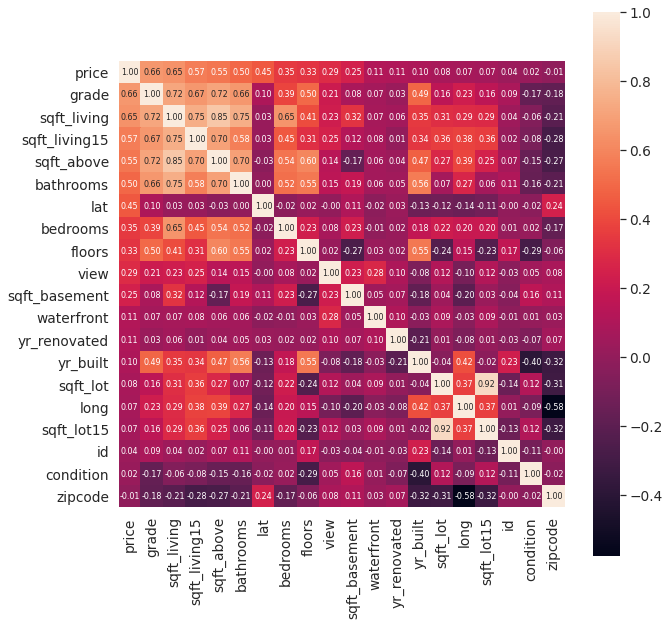

In [175]:
import scipy as sp

cor_abs = abs(train.corr(method='spearman')) 
cor_cols = cor_abs.nlargest(n=21, columns='price').index # price과 correlation이 높은 column 10개 뽑기(내림차순)

# spearman coefficient matrix
cor = np.array(sp.stats.spearmanr(train[cor_cols].values))[0] # 10 x 10
print(cor_cols.values)
plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, square=True , annot_kws={'size' : 8} ,xticklabels=cor_cols.values, yticklabels=cor_cols.values)

우리 구하고자 하는 것은 집값 예측하는 회귀문제이다.

본격적인 데이터 전처리 이전에 학습데이터의 라벨과 다른 특성과 상관관계를 파악한다.

그 결과 라벨인 price와는 grade, sqft_living, sqft_living15, sqft_above, bathrooms 가 순서대로 높은 상관관계를 가지고있다. 이를 기준으로 아래에서 데이터 전처리를 진행한다

한편 price와 상관관계가 상당히 낮은(약 r = 0.1 이하)도 전처리 과정에서 예의주시한다
즉 **zipcode condition id sqft_living15 long sqft_lot** 들

>> 2. 학습 데이터에서 라벨 제거하기

In [176]:
y = train['price']
del train['price']

print(data.columns)

print('train data dim : {}'.format(train.shape))
print('test data dim : {}'.format(test.shape))

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')
train data dim : (15035, 20)
test data dim : (6468, 20)


>> 2. 학습 데이터와 테스트 데이터 합치기

In [177]:
train_len = len(data)
data = pd.concat((data, sub), axis=0)

print(len(data))

34439


>> 3. date 칼럼 정수형 데이터로 처리  
>>이렇게 하면 모델이 date도 예측을 위한 특성으로 활용

In [179]:
'''
오류로 중지

data['date'] = data['date'].apply(lambda x : str(x[:6]))

data.head()

'''

"\n오류로 중지\n\ndata['date'] = data['date'].apply(lambda x : str(x[:6]))\n\ndata.head()\n\n"

>> 4. 결측치 확인

date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


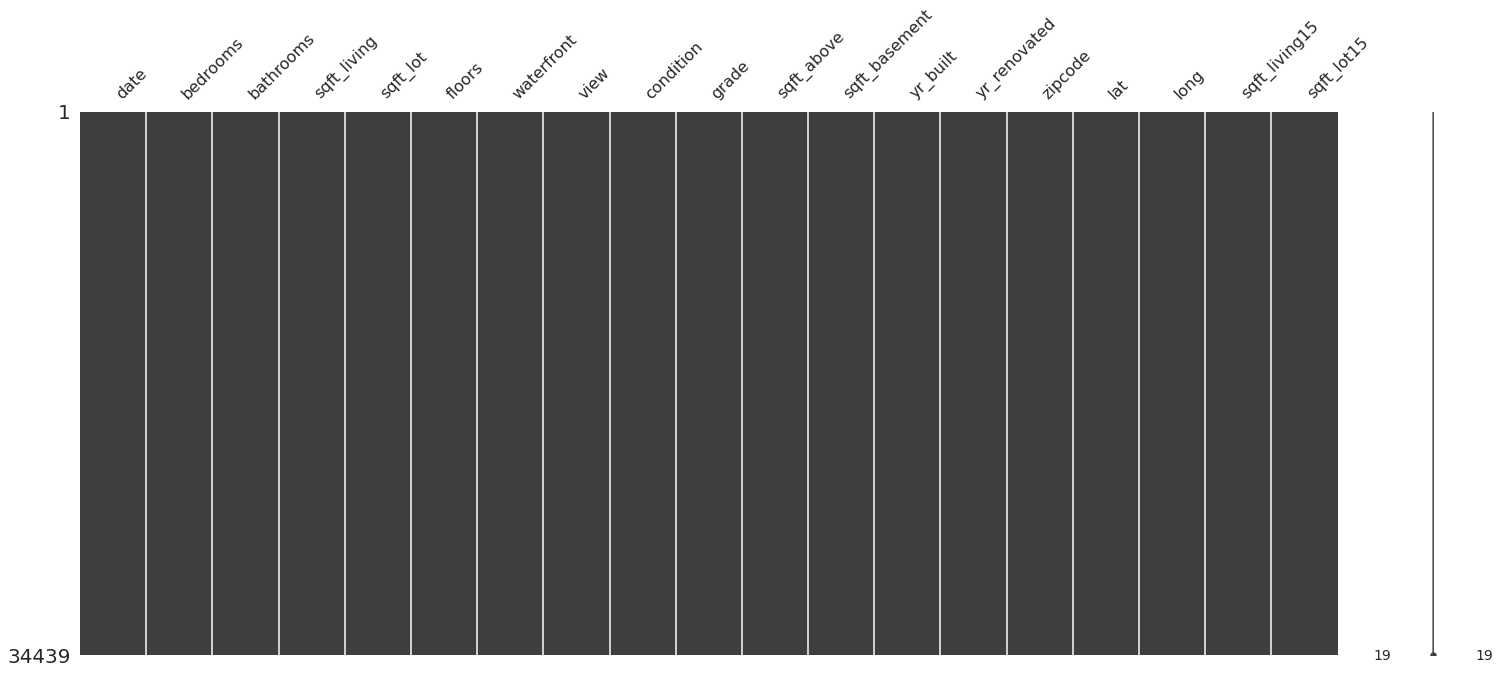

In [180]:
msno.matrix(data)

for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

>> 5. 변수 정리   
필요없는 id 칼럼 정리 제출 대비 sub_id에 저장



In [181]:
# 'zipcode', 'condition', 'id', 'sqft_living15', 'long sqft_lot'
# 위 상관계수가 r = 0.1 이하인 것들을 제거 한다.
# 아쉬운점 : for문 list에서 자동변수 생성을 하지못해 단순코드 반복을 했다.
# 그러나 오히려 rmse 값이 더 올라가서 원안대로 id만 제거함

sub_condition = data['id'][train_len:]
del data['id']


'''
sub_zipcode = train['zipcode'][train_len:]
del train['zipcode']

sub_condition = train['condition'][train_len:]
del train['condition']

sub_condition = train['sqft_living15'][train_len:]
del train['sqft_living15']

sub_condition = train['sqft_lot'][train_len:]
del train['sqft_lot']
'''

print(data.columns)

KeyError: 'id'

>> 6. 가격데이터 분포 확인

In [ ]:
# 가격데이터 분포확인
sns.kdeplot(y)
plt.show()

# 로그변환
y = np.log1p(y)
sns.kdeplot(y)
plt.show()

로그 변환을 취하면, 0에 가깝게 몰려있는 데이터들은 넓게 퍼질 것이고, 매우 크게 퍼져있는 소수의 데이터들은 작은 y값으로 모일 것으로 **정규성**을 가지고**의미있는 데이터를 파악**할 수있다

In [ ]:
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

print(x.shape)
print(sub.shape)

> ##### 3. 모델설계

>> 1. 모델설계 이전 RMSE 함수화

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

print('끙끙💢')

y_test나 y_pred는 위에서 np.log1p()로 변환이 된 값이기 때문에 원래 데이터의 단위에 맞게 되돌리기 위해 np.expm1()을 추가 함

exp로 다시 변환해서 mean_squared_error를 계산한 값에 np.sqrt를 취하면 RMSE 값을 얻을 수 있음

>> 2. 모델 설계 (함수화)

In [ ]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다. 
#random_state=None    # 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택합니다.  
random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

print('얍💢')

각 모델의 이름은 다음과 같이 클래스의 __name__ 속성에 접근해서 얻기 가능

In [ ]:
gboost.__class__.__name__

In [ ]:
def get_scores(models, train, y):
    # 답안 작성
    
    df = {}

    for model in models:
        # 모델 이름 획득
        model_name = model.__class__.__name__

        # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

        # 모델 학습
        model.fit(X_train, y_train)
    
        # 예측
        y_pred = model.predict(X_test)

        # 예측 결과의 rmse값 저장
        df[model_name] = rmse(y_test, y_pred)
    
        # data frame에 저장
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
    return score_df
    
get_scores(models, data, y)

> ##### 4. 그리드탐색

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [10, 50, 100, 150,200,300],
    'max_depth': [1,5,10,15,20,30]
}

model = LGBMRegressor(random_state=random_state)

print('얍💢')

In [ ]:
"""
다음과 같은 과정을 진행할 수 있는 `my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)` 함수를 구현해 보세요.

1. GridSearchCV 모델로 `model`을 초기화합니다.
2. 모델을 fitting 합니다.
3. params, score에 각 조합에 대한 결과를 저장합니다. 
4. 데이터 프레임을 생성하고, RMSLE 값을 추가한 후 점수가 높은 순서로 정렬한 `results`를 반환합니다.
"""

# 코드 입력

def my_GridSearch(model, train, y, param_grid, verbose, n_jobs):
    
    #1. GridSearchCV 모델로 `grid_model`을 초기화합니다.
    grid_model = GridSearchCV(model, param_grid=param_grid, \
                          #param_grid : 탐색할 파라미터의 종류 (딕셔너리로 입력)
                        scoring='neg_mean_squared_error', \
                          #scoring : 모델의 성능을 평가할 지표
                        cv=5, verbose = verbose, n_jobs = n_jobs)
        #cv : cross validation을 수행하기 위해 train 데이터셋을 나누는 조각의 개수
        #verbose : 그리드 탐색을 진행하면서 진행 과정을 출력해서 보여줄 메세지의 양 
                    #(숫자가 클수록 더 많은 메세지를 출력합니다.)
        #n_jobs : 그리드 탐색을 진행하면서 사용할 CPU의 개수
    
    #2. 모델을 fitting 합니다.
    grid_model.fit(train, y)
    grid_model.cv_results_
    
    #3. params, score에 각 조합에 대한 결과를 저장합니다. 
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    #4. 데이터 프레임을 생성하고, RMSLE 값을 추가한 후 점수가 높은 순서로 정렬한 `results`를 반환합니다.
    results = pd.DataFrame(params)
    results['score'] = score
    results['RMSE'] = np.sqrt(-1 * results['score'])
    results = results.rename(columns={'RMSE': 'RMSLE'})
    results =results.sort_values('RMSLE')

    return results



    
    
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

가장 좋은 조합은 max_depth=30, n_estimators=300 이군요. 해당 모델로 학습을 해서 예측값인 submission.csv 파일을 만들어서 제출

해당 파라미터로 구성된 모델을 준비하고, 학습 후 예측 결과를 생성

In [ ]:
"""
아래의 과정을 수행하는 `save_submission(model, train, y, test, model_name, rmsle)` 함수를 구현해 주세요.
1. 모델을 `train`, `y`로 학습시킵니다.
2. `test`에 대해 예측합니다.
3. 예측값을 `np.expm1`으로 변환하고, `submission_model_name_RMSLE_100000.csv` 형태의 `csv` 파일을 저장합니다.
"""

# 코드 작성

def save_submission(model, train, y, test, model_name, rmsle):
    
    #1. 모델을 `train`, `y`로 학습시킵니다.
    model.fit(train, y)
    
    #2.`test`에 대해 예측합니다.
    prediction = model.predict(test)
    
    #3. 예측값을 `np.expm1`으로 변환하고, `submission_model_name_RMSLE_100000.csv` 형태의 `csv` 파일을 저장
    prediction = np.expm1(prediction)
    
    
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)

    #데이터프레임에 우리의 모델이 예측한 값을 덮어씌우면 제출할 데이터가 완성
    submission['price'] = prediction
    
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    
    print('yes! \n {} saved!'.format(submission_csv_path))
    
    
save_submission(model, train, y, c, 'lgbm', rmsle='0.0168')
    

# 회고

이번주도 변수가 꼬여서 다시 손 댓다가 모든게 꼬여보려서 마지막에 제대로 하지못했다... 너무 아쉽다